In [4]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
sns.set()
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor="white")

# Load data

In [7]:
# extract file
file = tarfile.open('500_hgmm_3p_LT_Chromium_X_raw_feature_bc_matrix.tar.gz')
file.extractall(r'C:\Users\ENESSEFAAYAR\Desktop\scRNA-Seq Practice')
file.close()

# AnnData Structure
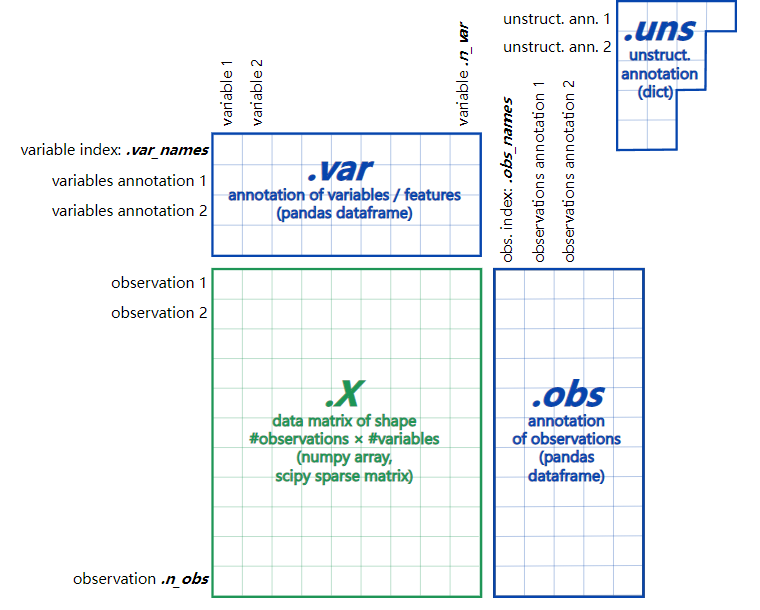

In [11]:
path = r"C:\Users\ENESSEFAAYAR\Desktop\scRNA-Seq Practice\raw_feature_bc_matrix"

# This function combine 3 files and create anndata object (matrix,features and barcodes).
adata = sc.read_10x_mtx(path, var_names="gene_symbols", cache=True) 

# Convert csr matrix (.X) to 2D-numpy array
adata.X = adata.X.toarray()


... writing an h5ad cache file to speedup reading next time


# Exploratory Analysis

obs keys: <bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 14401 × 68886
    var: 'gene_ids', 'feature_types'>
normalizing counts per cell


C:\Users\ENESSEFAAYAR\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


    finished (0:00:01)


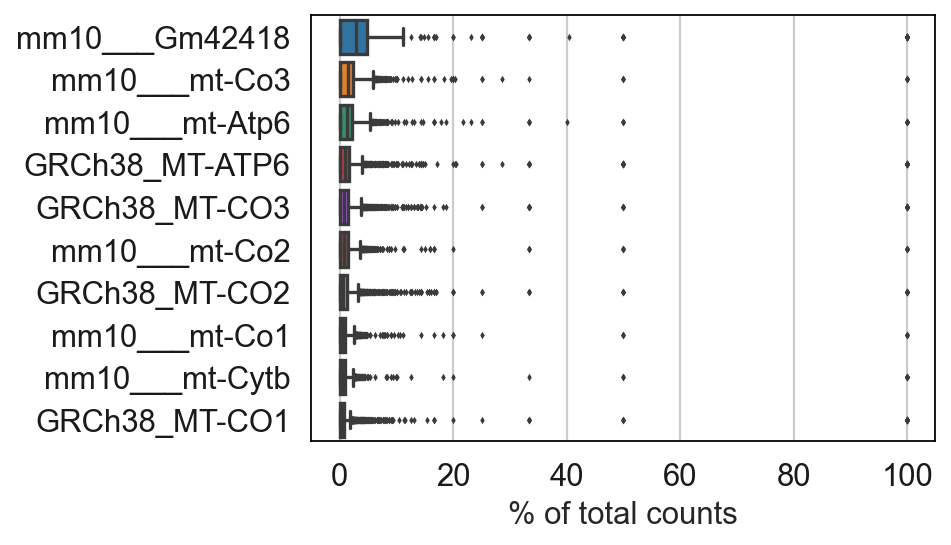

... storing 'feature_types' as categorical


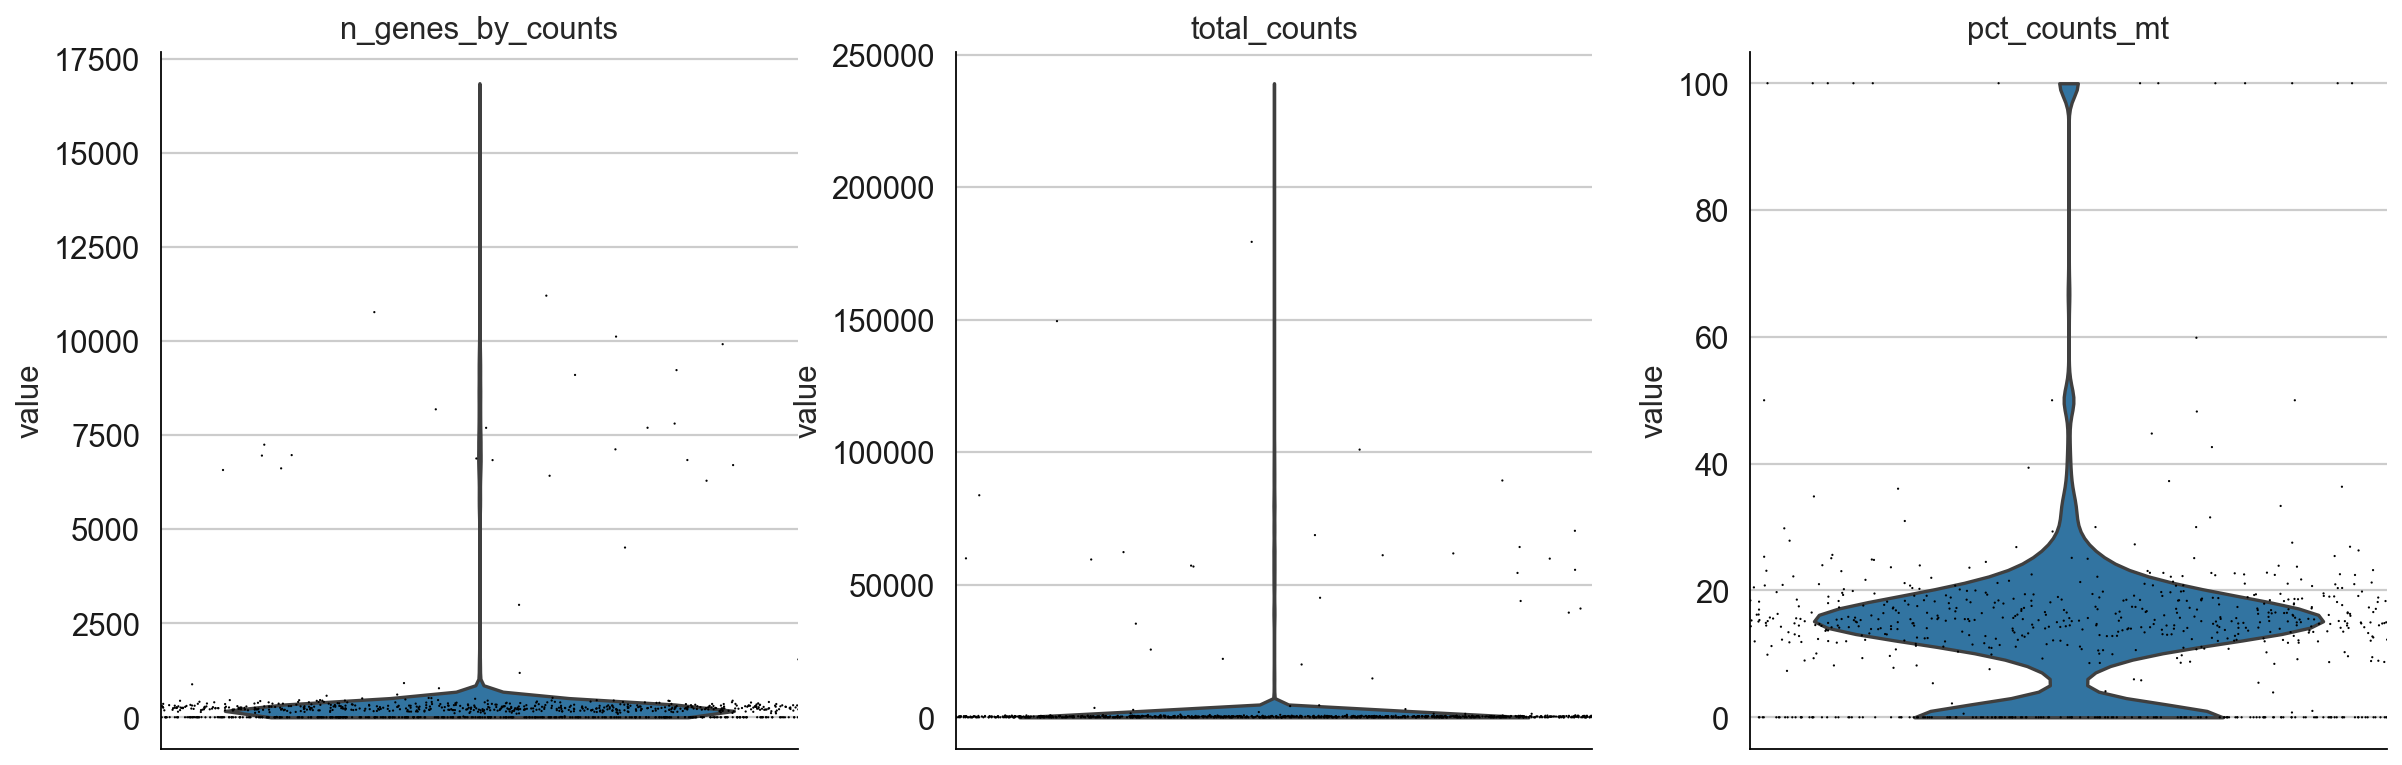

In [12]:
print("obs keys:",adata.obs_keys)

# Finds genes that has highest count in the data
sc.pl.highest_expr_genes(adata, n_top=10)

# annotate mitochondrial genes as mt and calculate qc metrics
adata.var["mt"] = np.array(adata.var_names.str.contains("mt-")) + np.array(adata.var_names.str.contains("MT-"))

# Violin plot with QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top = None, log1p = False, inplace = True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=8.4, multi_panel=True)

C:\Users\ENESSEFAAYAR\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


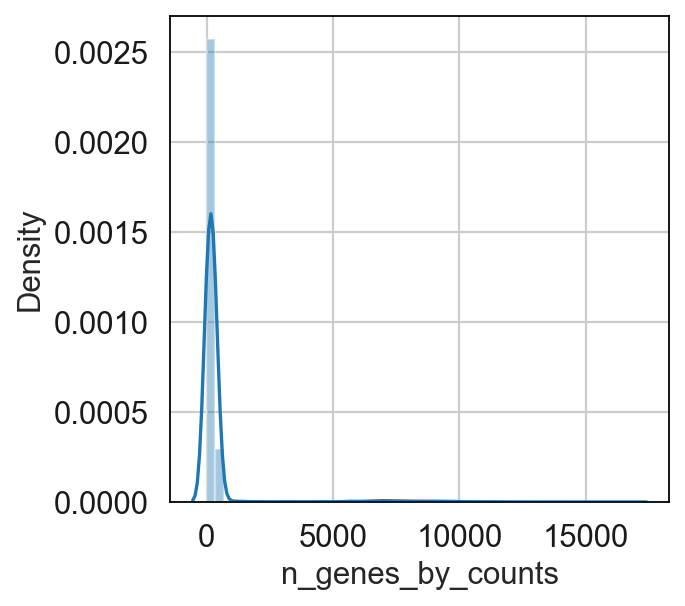

C:\Users\ENESSEFAAYAR\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


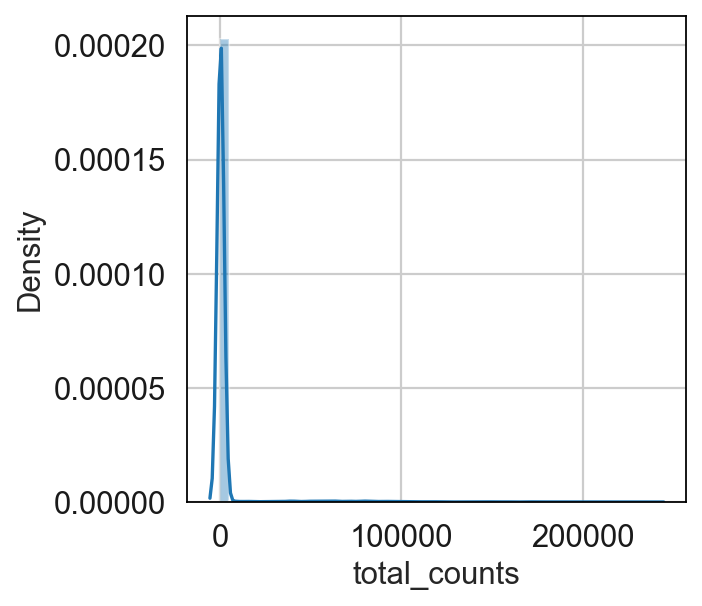

In [13]:
# Histogram(distribution) of QC metrics
sns.distplot(adata.obs["n_genes_by_counts"])
plt.show()
ax = plt.gca()
plt.savefig(r"Figure1")
sns.distplot(adata.obs["total_counts"])
plt.show()

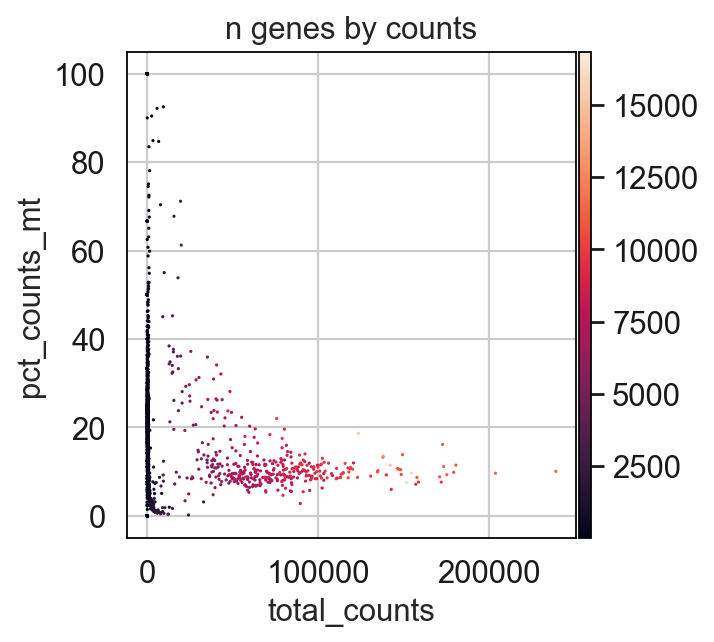

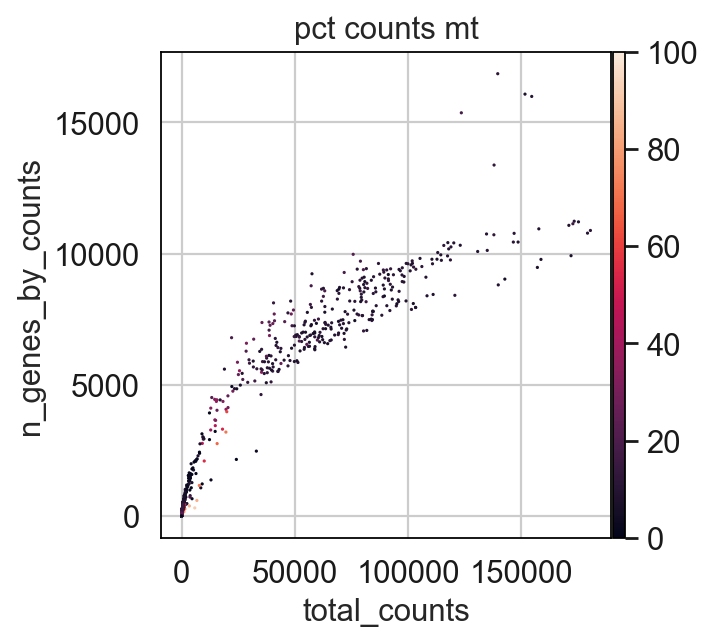

In [14]:
# Scatter Plot of QC metrics
sc.pl.scatter(adata, x = "total_counts", y="pct_counts_mt", color = "n_genes_by_counts", save=r"Figure2.png")
sc.pl.scatter(adata, x = "total_counts", y="n_genes_by_counts", color = "pct_counts_mt", save=r"Figure3.png")

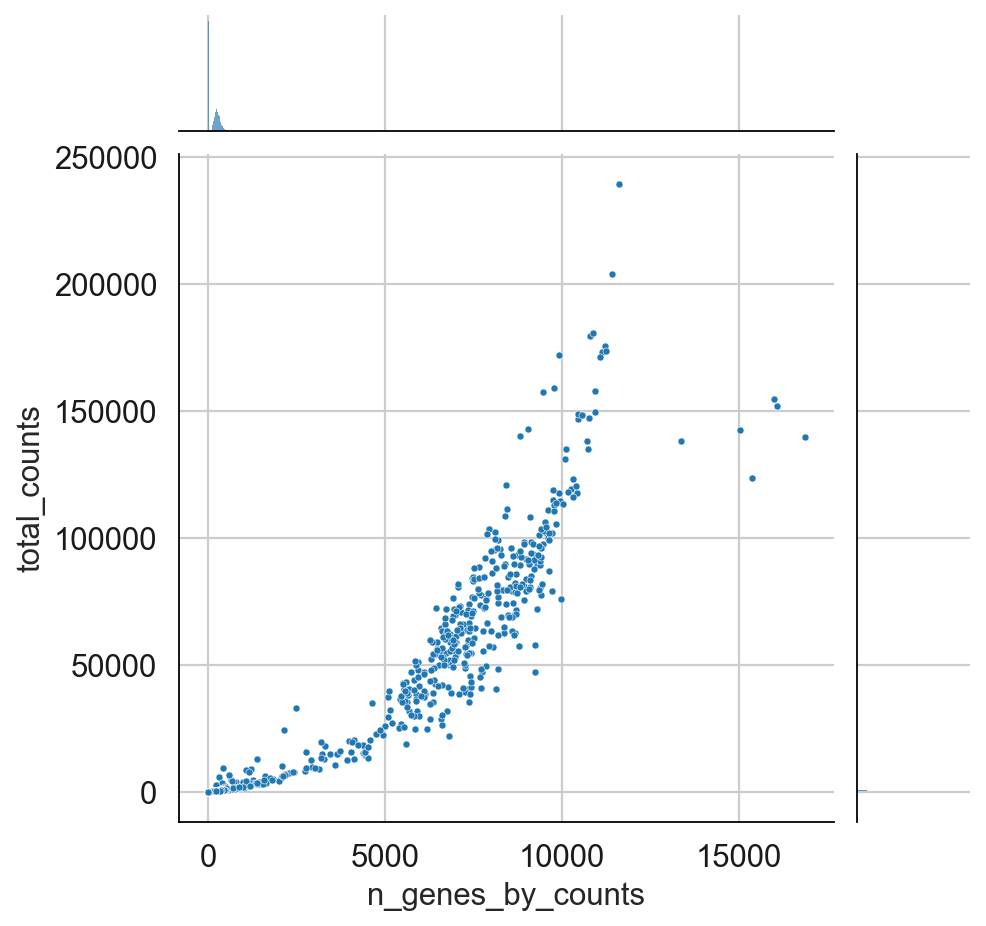

In [15]:
# Joint distribution 
sns.jointplot(x = "n_genes_by_counts",
              y = "total_counts",
              data = adata.obs,
              kind = "scatter",
              s = 10)
ax = plt.gca()
plt.savefig(r"Figure4")

# QC Analysis

filtered out 5287 cells that have less than 100 genes expressed
filtered out 37639 genes that are detected in less than 3 cells
filtered out 273 cells that have more than 50000 counts
(103, 31247)


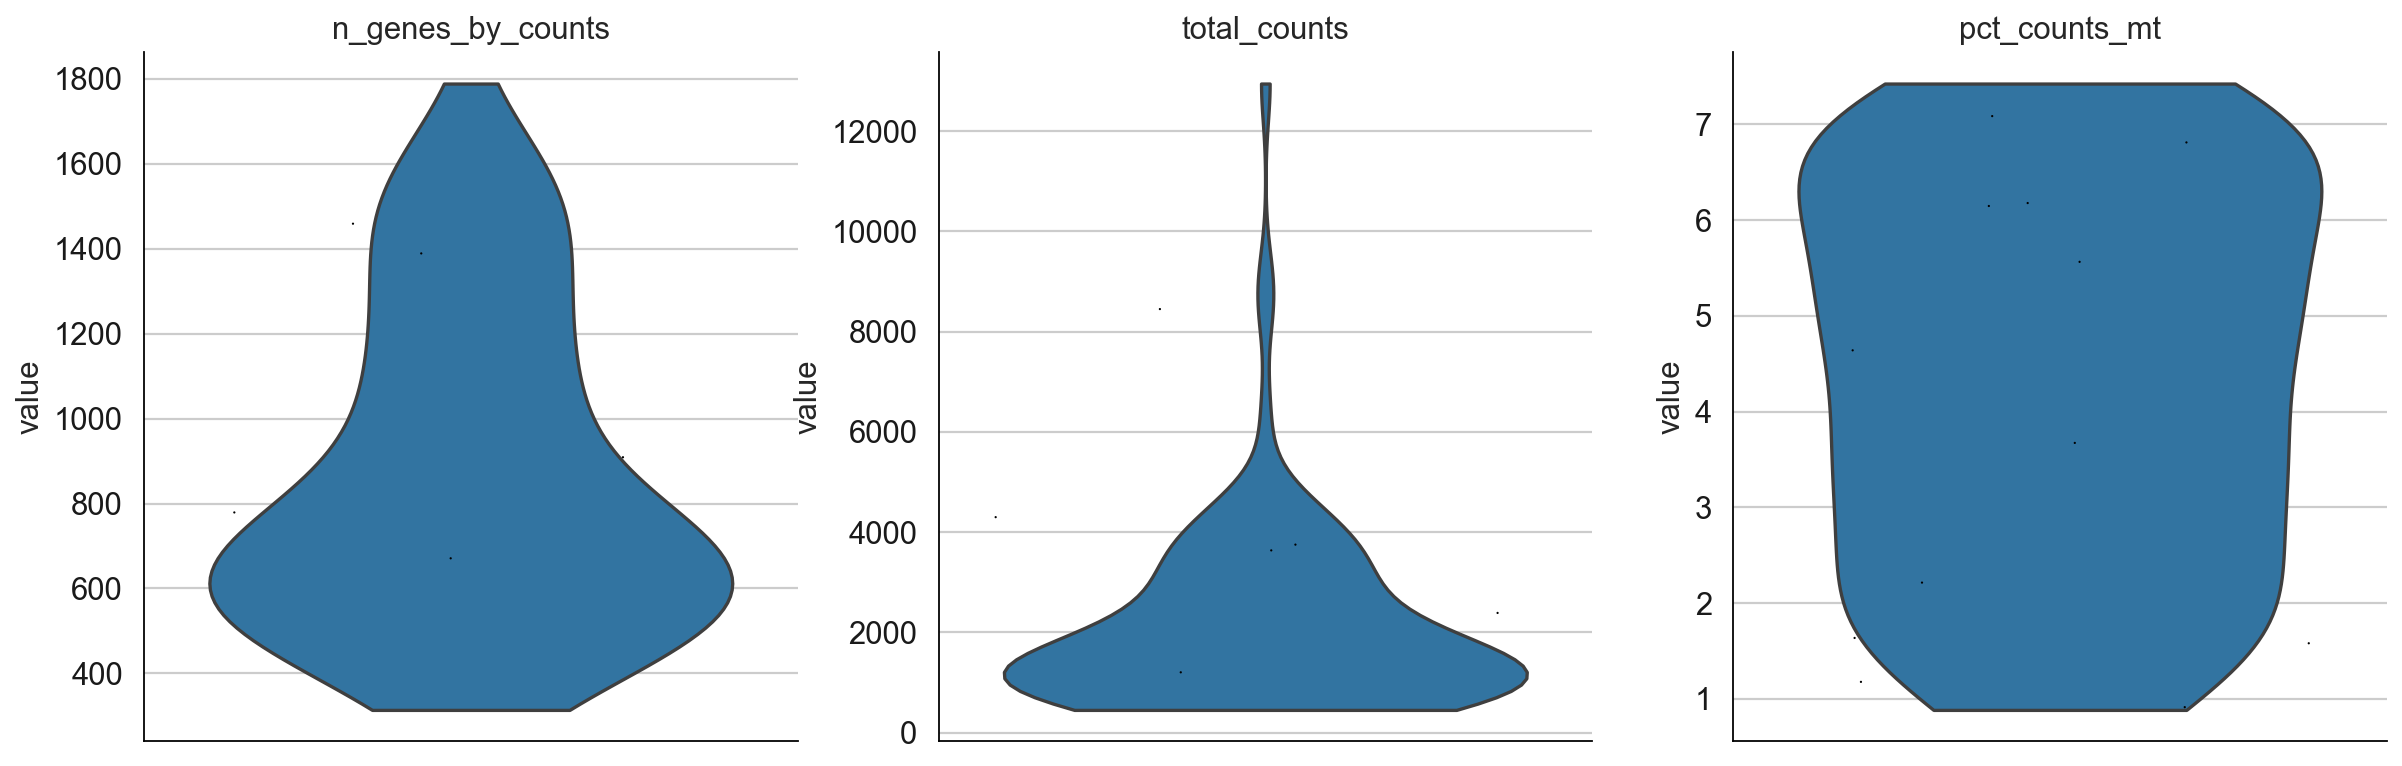

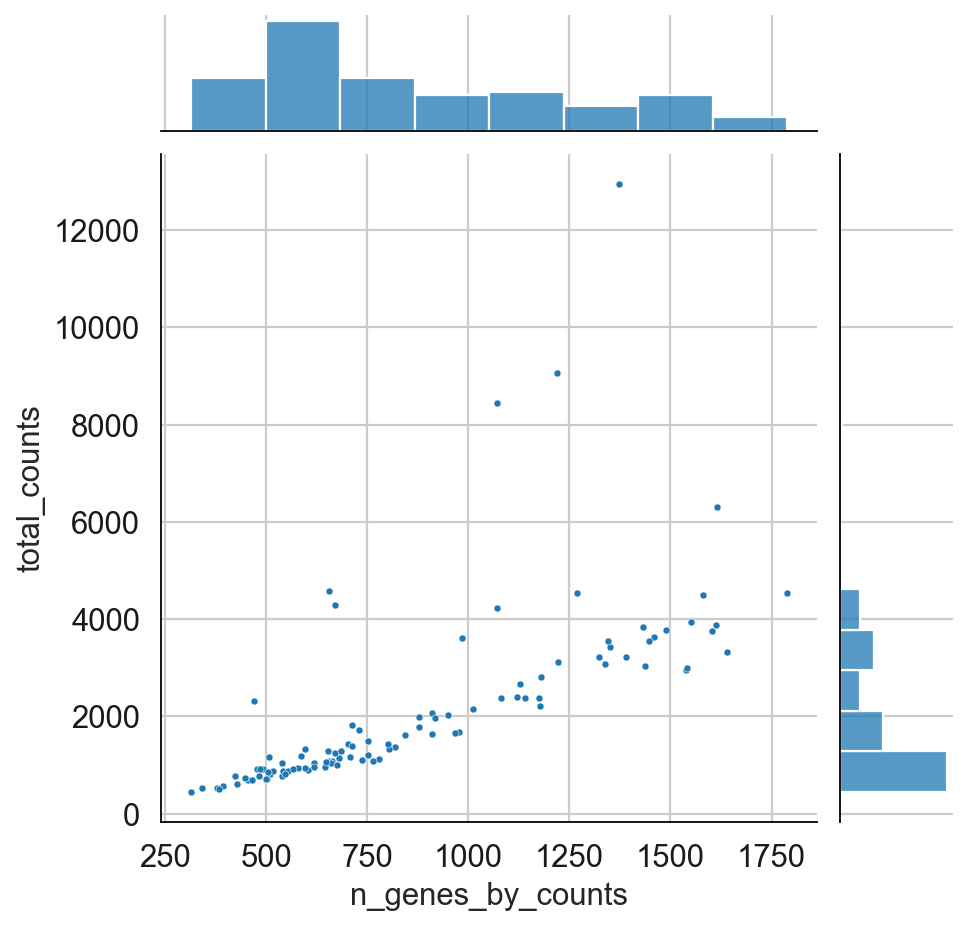

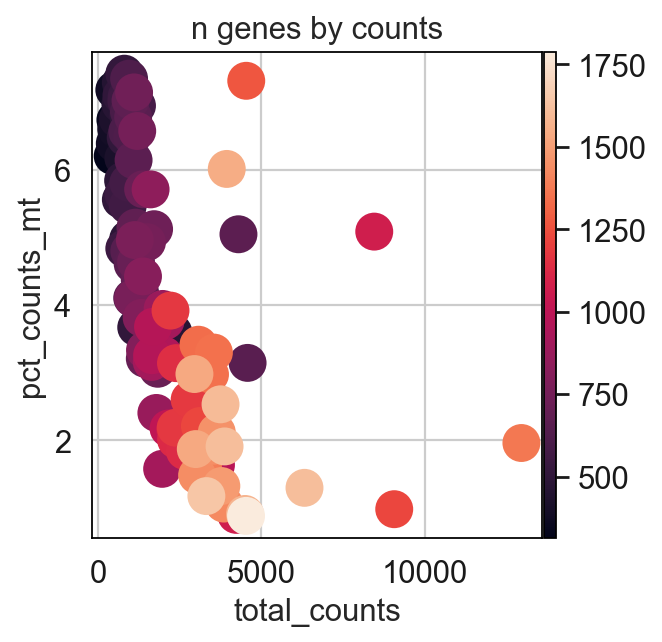

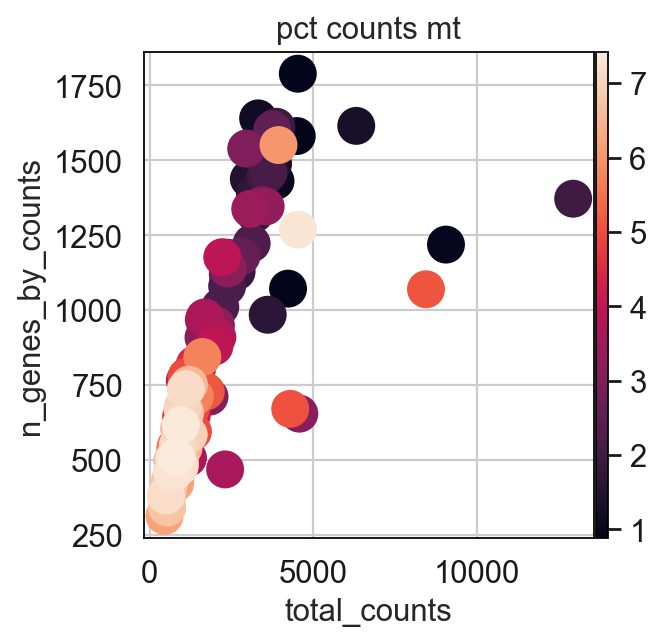

C:\Users\ENESSEFAAYAR\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


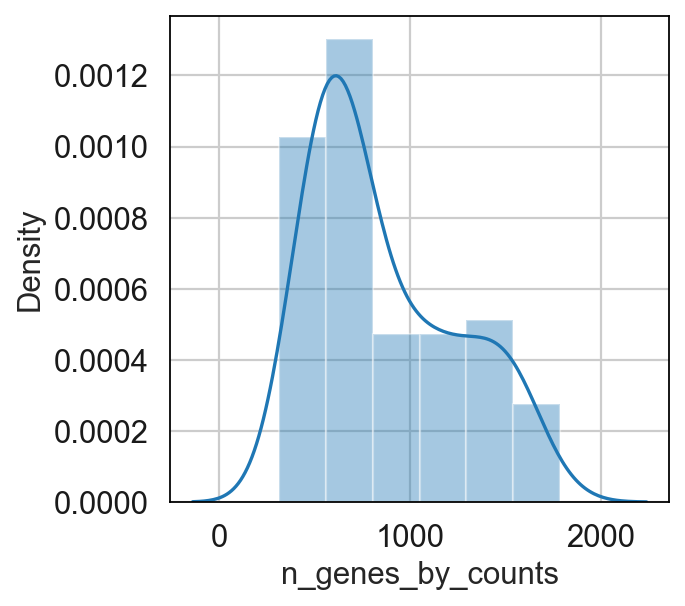

In [16]:
# Basic Filtering (These are inplace!!!)
QC_data = adata.copy() # To keep original adata, make a copy for Quality Control
sc.pp.filter_cells(QC_data, min_genes=100) # Filter cells that have less than 100 genes determined
sc.pp.filter_genes(QC_data, min_cells=3) # Filter genes that are found in less than 3 cells
sc.pp.filter_cells(QC_data, max_counts=50000) # Filter cells that have more than 50,000 total counts

# Filter by slicing
QC_data = QC_data[QC_data.obs.n_genes_by_counts < 1800,:] # Select number of genes detected less than 1800
QC_data = QC_data[QC_data.obs.pct_counts_mt < 7.5,:] # Select mitochondrial gene percent is less than 7.5%

# Check new number of cells and genes remained.
print(QC_data.X.shape)
sc.pl.violin(QC_data, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=8.4, multi_panel=True)

# Joint distribution 
sns.jointplot(x = "n_genes_by_counts",
              y = "total_counts",
              data = QC_data.obs,
              kind = "scatter",
              s = 10)
ax = plt.gca()
plt.savefig(r"Figure4Corrected")

# Scatter Plot of QC metrics
sc.pl.scatter(QC_data, x = "total_counts", y="pct_counts_mt", color = "n_genes_by_counts", save=r"Figure2Corrected.png")
sc.pl.scatter(QC_data, x = "total_counts", y="n_genes_by_counts", color = "pct_counts_mt", save=r"Figure3Corrected.png")

# Histogram of QC metrics
sns.distplot(QC_data.obs["n_genes_by_counts"])
ax = plt.gca()
plt.savefig(r"Figure1Corrected")

normalizing counts per cell
    finished (0:00:00)


C:\Users\ENESSEFAAYAR\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


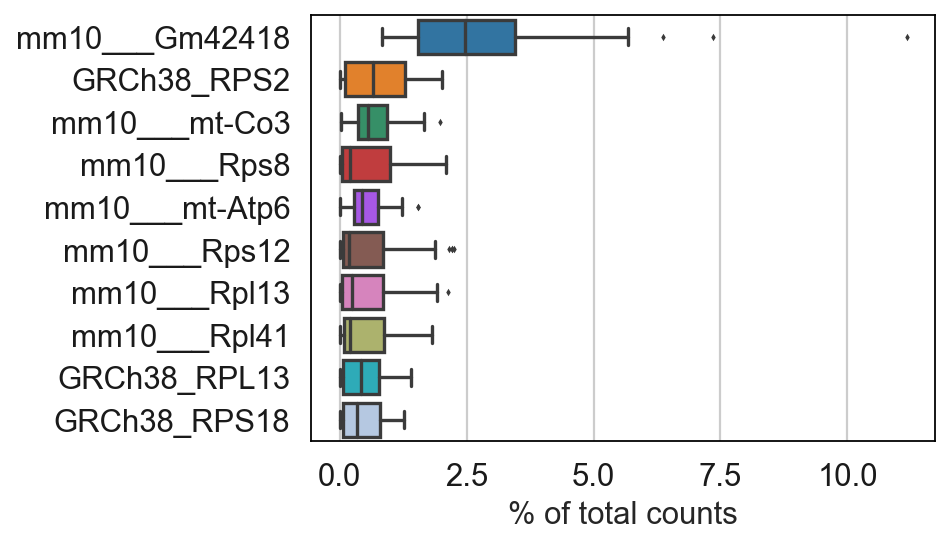

In [17]:
sc.pl.highest_expr_genes(QC_data, n_top=10)

# Normalization, Dimensionality Reduction, Determining HVGs

In [18]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from kneed import KneeLocator as kl

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


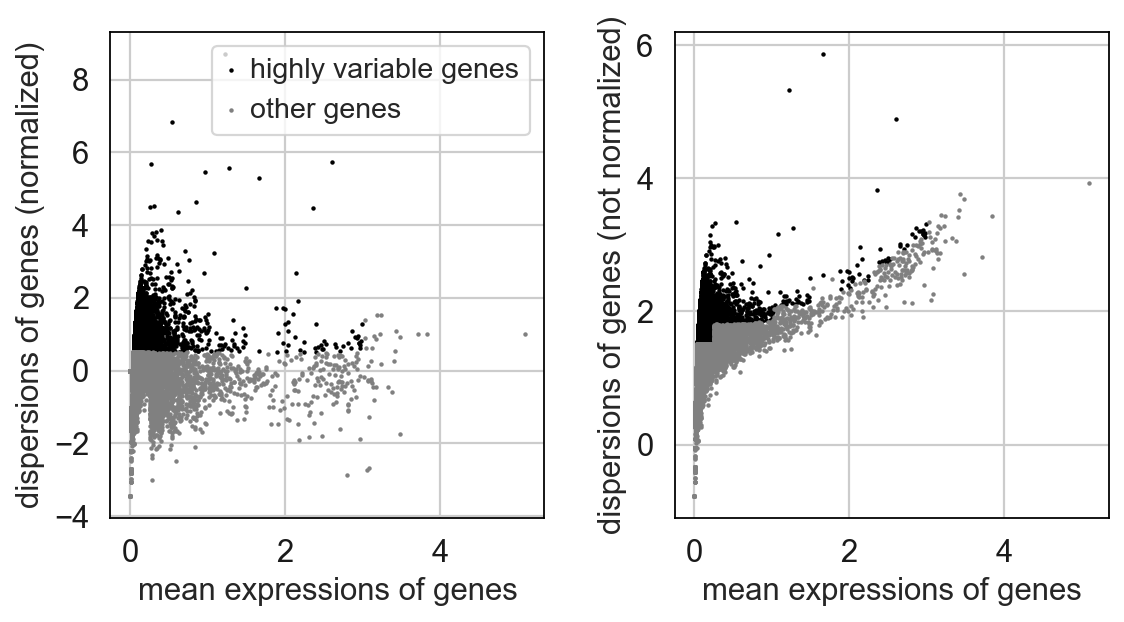

In [19]:
# Normalize counts to 10,000 count per celll
norm_data = QC_data.copy() # Again make a copy of QC for normalized data
sc.pp.normalize_total(norm_data, target_sum= 6000)

# log(x+1) transform
sc.pp.log1p(norm_data)

# Identify highly variable genes
# min_mean excludes zero counts which has zero means.
# max_mean excludes too variable genes which may amplified etc.
sc.pp.highly_variable_genes(norm_data, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot dispersion vs expression
sc.pl.highly_variable_genes(norm_data)

computing PCA
    on highly variable genes
    with n_comps=102
    finished (0:00:00)


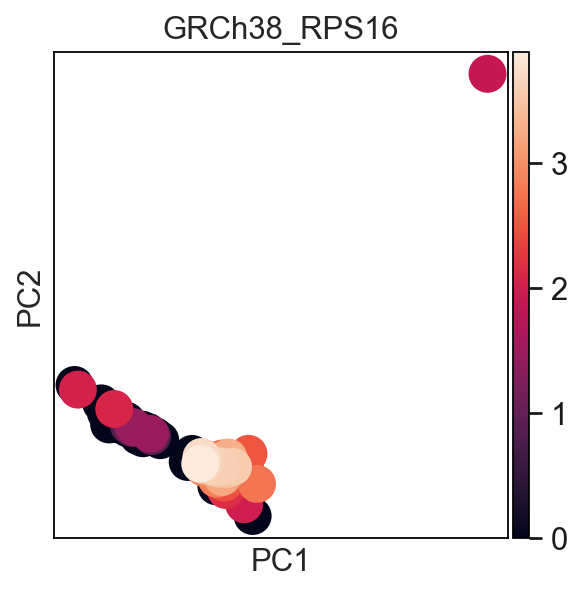

C:\Users\ENESSEFAAYAR\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ENESSEFAAYAR\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


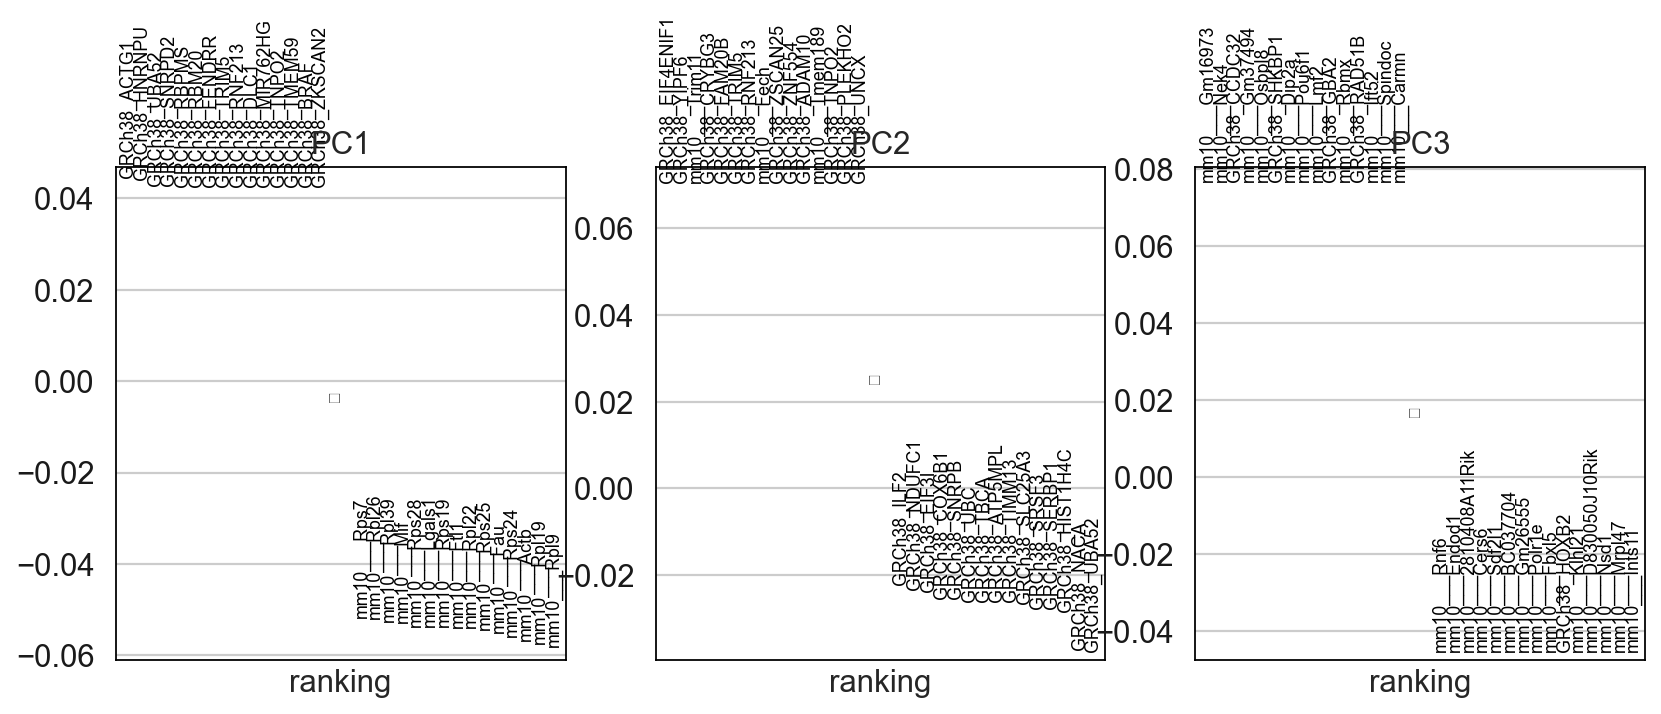

In [20]:
# Again make a copy for HVGs to keep normalized data
HVG_data = norm_data.copy() 

# Filter to only include HVGs
HVG_data.raw = HVG_data
HVG_data = HVG_data[:, HVG_data.var.highly_variable]

pc_HVG_data = HVG_data.copy()

# Scale to unit variance for PCA, clip values exceeding var 10
sc.pp.scale(pc_HVG_data, max_value = 10)

# Reduce the dimensionality of the data by PCA
# n_comps is number of principal comp.(dimensions) we want to analyze
sc.pp.pca(pc_HVG_data, svd_solver = "arpack", n_comps = 102)

# Scatter in the PCA coordinates of HVGs, only for visualization
sc.pl.pca(pc_HVG_data, color = "GRCh38_RPS16")

# Plot contribution of each gene to PCA
sc.pl.pca_loadings(pc_HVG_data)



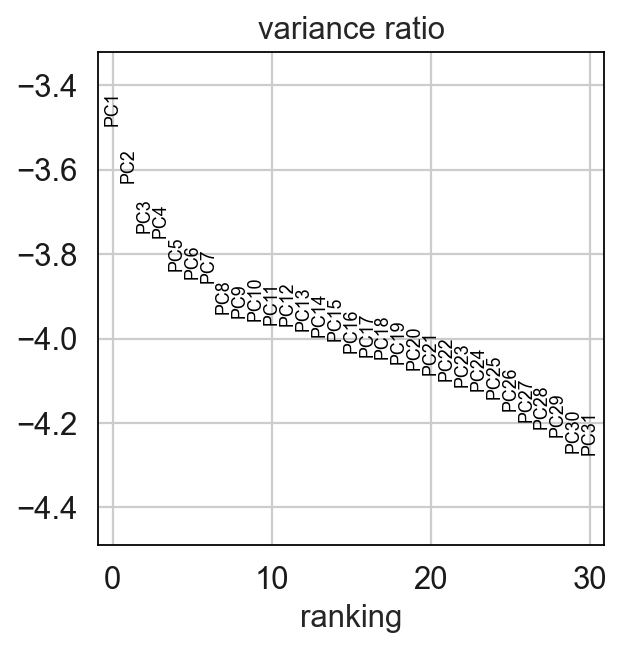

In [21]:
# How many PCs we quantify the similarity of gene contributions to PCs?

# How many PCs should we use to cluster?
# Visualize scree plot

sc.pl.pca_variance_ratio(pc_HVG_data, log=True)

def PCA_Elbow_fit(data):
    model = PCA().fit(data)
    explained_variance = model.explained_variance_ratio_
    pcs = list(range(1,explained_variance.shape[0] + 1))
    klm = kl(pcs, explained_variance, S = 1.0, curve="convex", direction="decreasing")
    pcs_used = klm.knee
    pc_list = list(range(1, pcs_used+1))
    new_data = PCA(n_components=pcs_used, svd_solver="arpack").fit_transform(data)
    return pcs_used, new_data, pcs, explained_variance, pc_list

In [22]:
# Extract cell X gene data from scanpy AnnData and create new pandas data frame
new_frame = pd.DataFrame(HVG_data.X, index=HVG_data.obs_names, columns=HVG_data.var_names)
pandas_data = new_frame.values

# Execute PCA elbow fitting function
dim, new_matrix, pc_ax, pc_ay, col_labels = PCA_Elbow_fit(pandas_data)
print("Number of pcs to represent data best:",dim)


Number of pcs to represent data best: 3


                         PC_1      PC_2      PC_3
ACAGAAAAGCGAATGC-1  13.446171 -0.574938 -0.198182
ACAGAAACAGACCTAT-1  12.733296  0.739207 -0.852647
ACAGAAAGTCAAGCGA-1  -5.985370 -1.610782 -1.296000
ACCCTTGCAAGAGTAT-1  -5.977781  2.197782  0.161108
ACCCTTGGTATGCGTT-1  -8.418541 -0.427278 -0.299570
(103, 3)


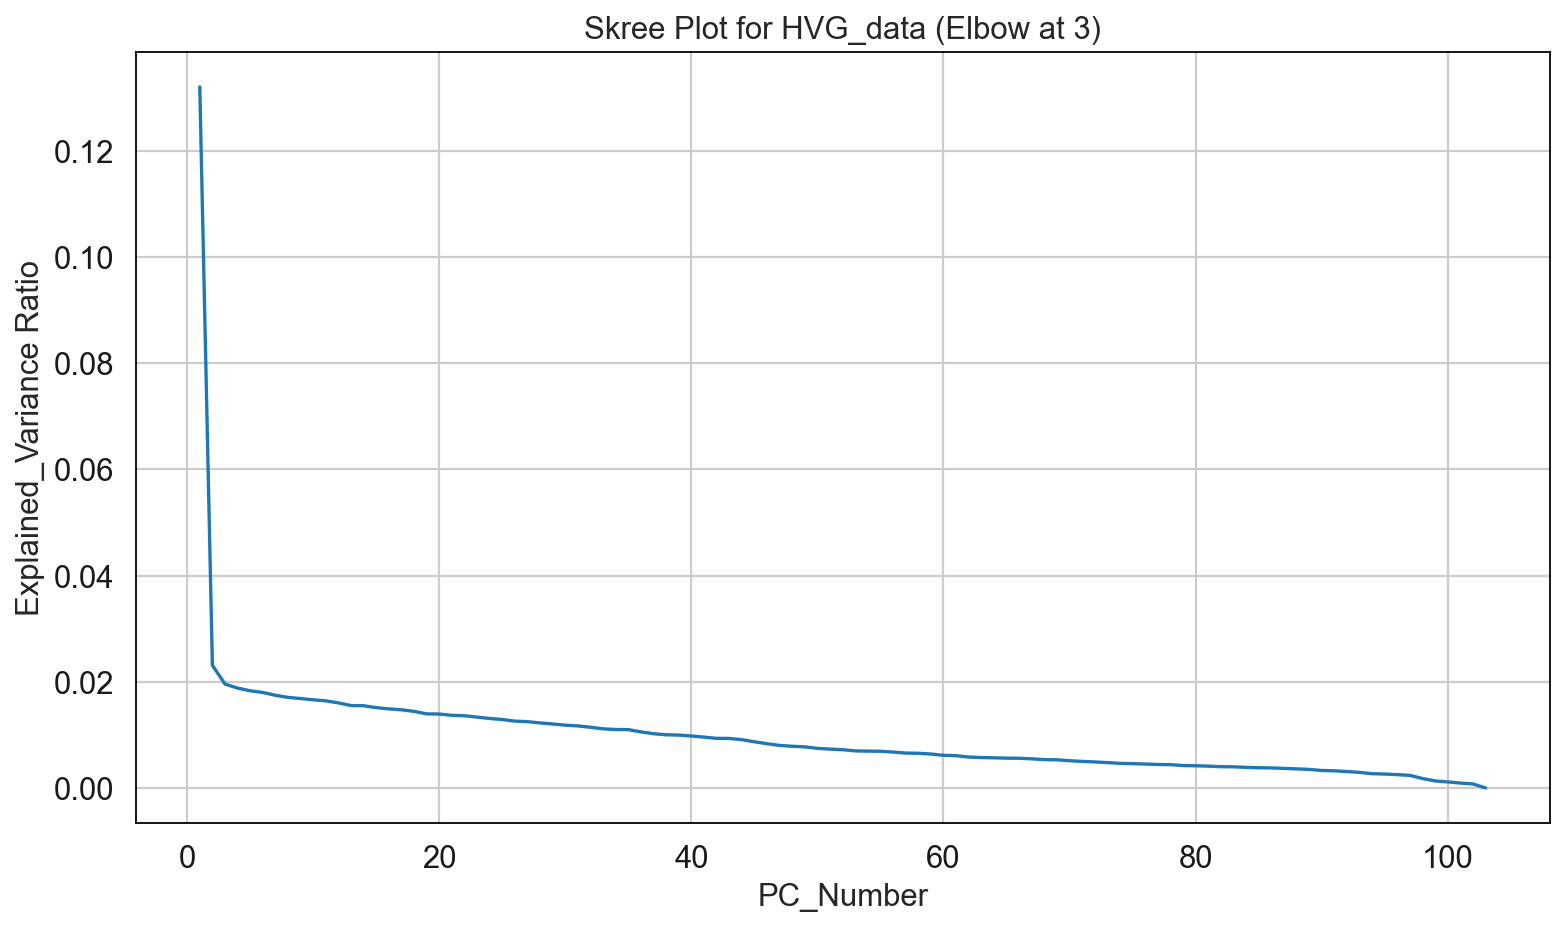

In [23]:
#create new data frame of cells X PC values
columns = ["PC_" + str(i) for i in col_labels]
PC_frame = pd.DataFrame(new_matrix, index = new_frame.index.values.tolist(), columns = columns)
print(PC_frame.head())
print(PC_frame.shape)

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.set_title("Skree Plot for " + "HVG_data" + " (Elbow at " + str(dim) + ")")
ax1.plot(pc_ax, pc_ay)
ax1.set_xlabel("PC_Number")
ax1.set_ylabel("Explained_Variance Ratio")
fig.tight_layout()
plt.savefig("Figure6")

# Clustering

computing neighbors
    using 'X_pca' with n_pcs = 3
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


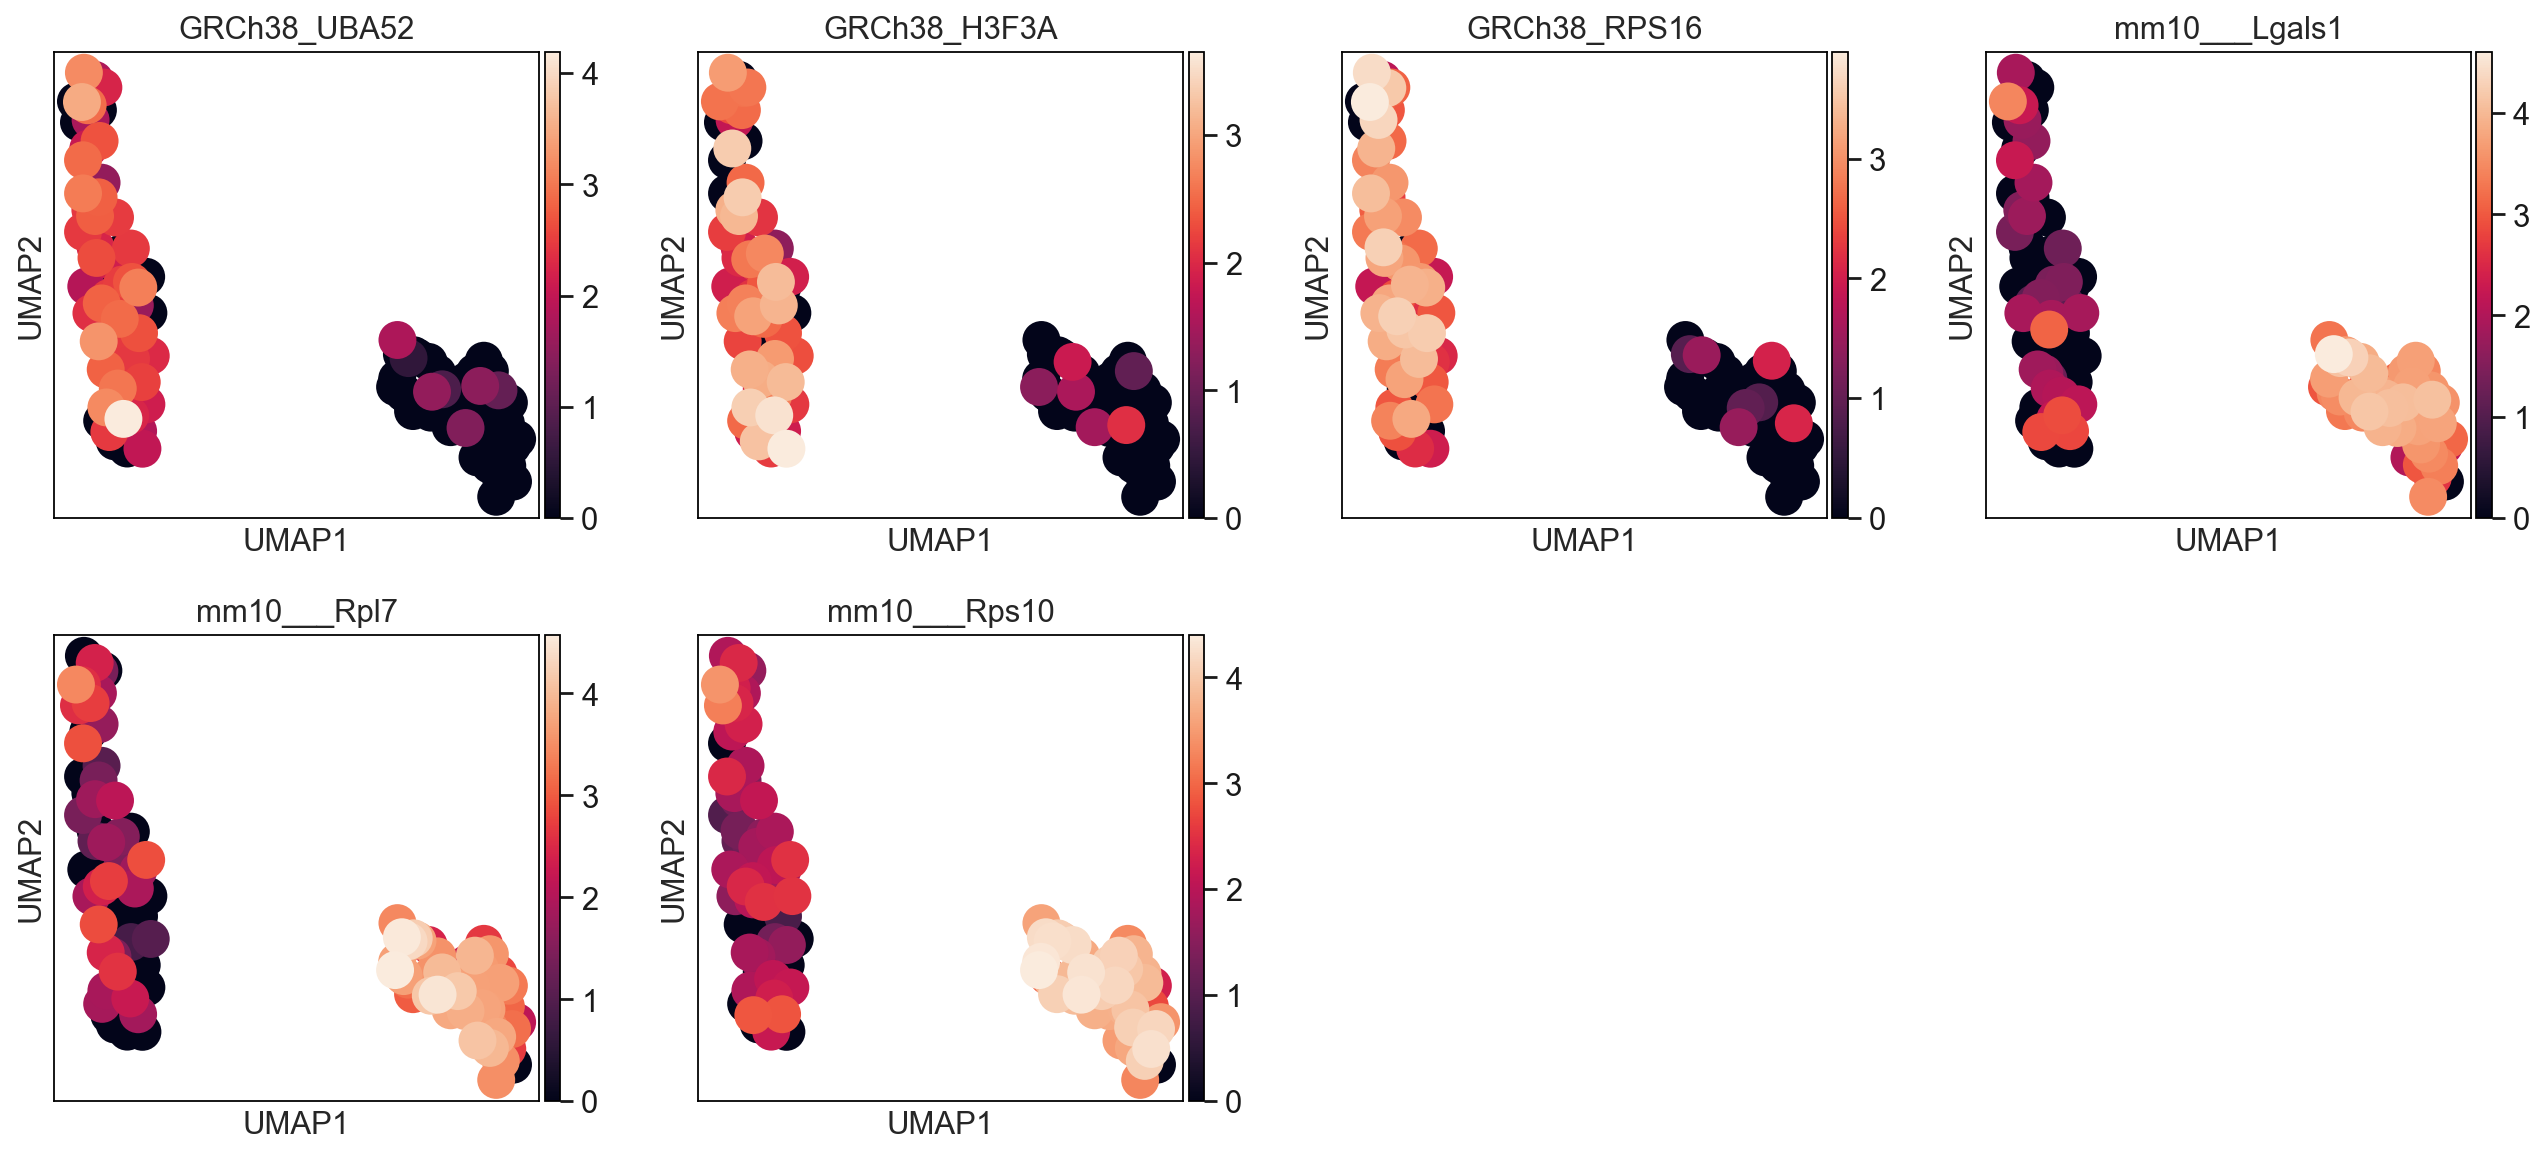

computing tSNE
    using 'X_pca' with n_pcs = 3
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:00)


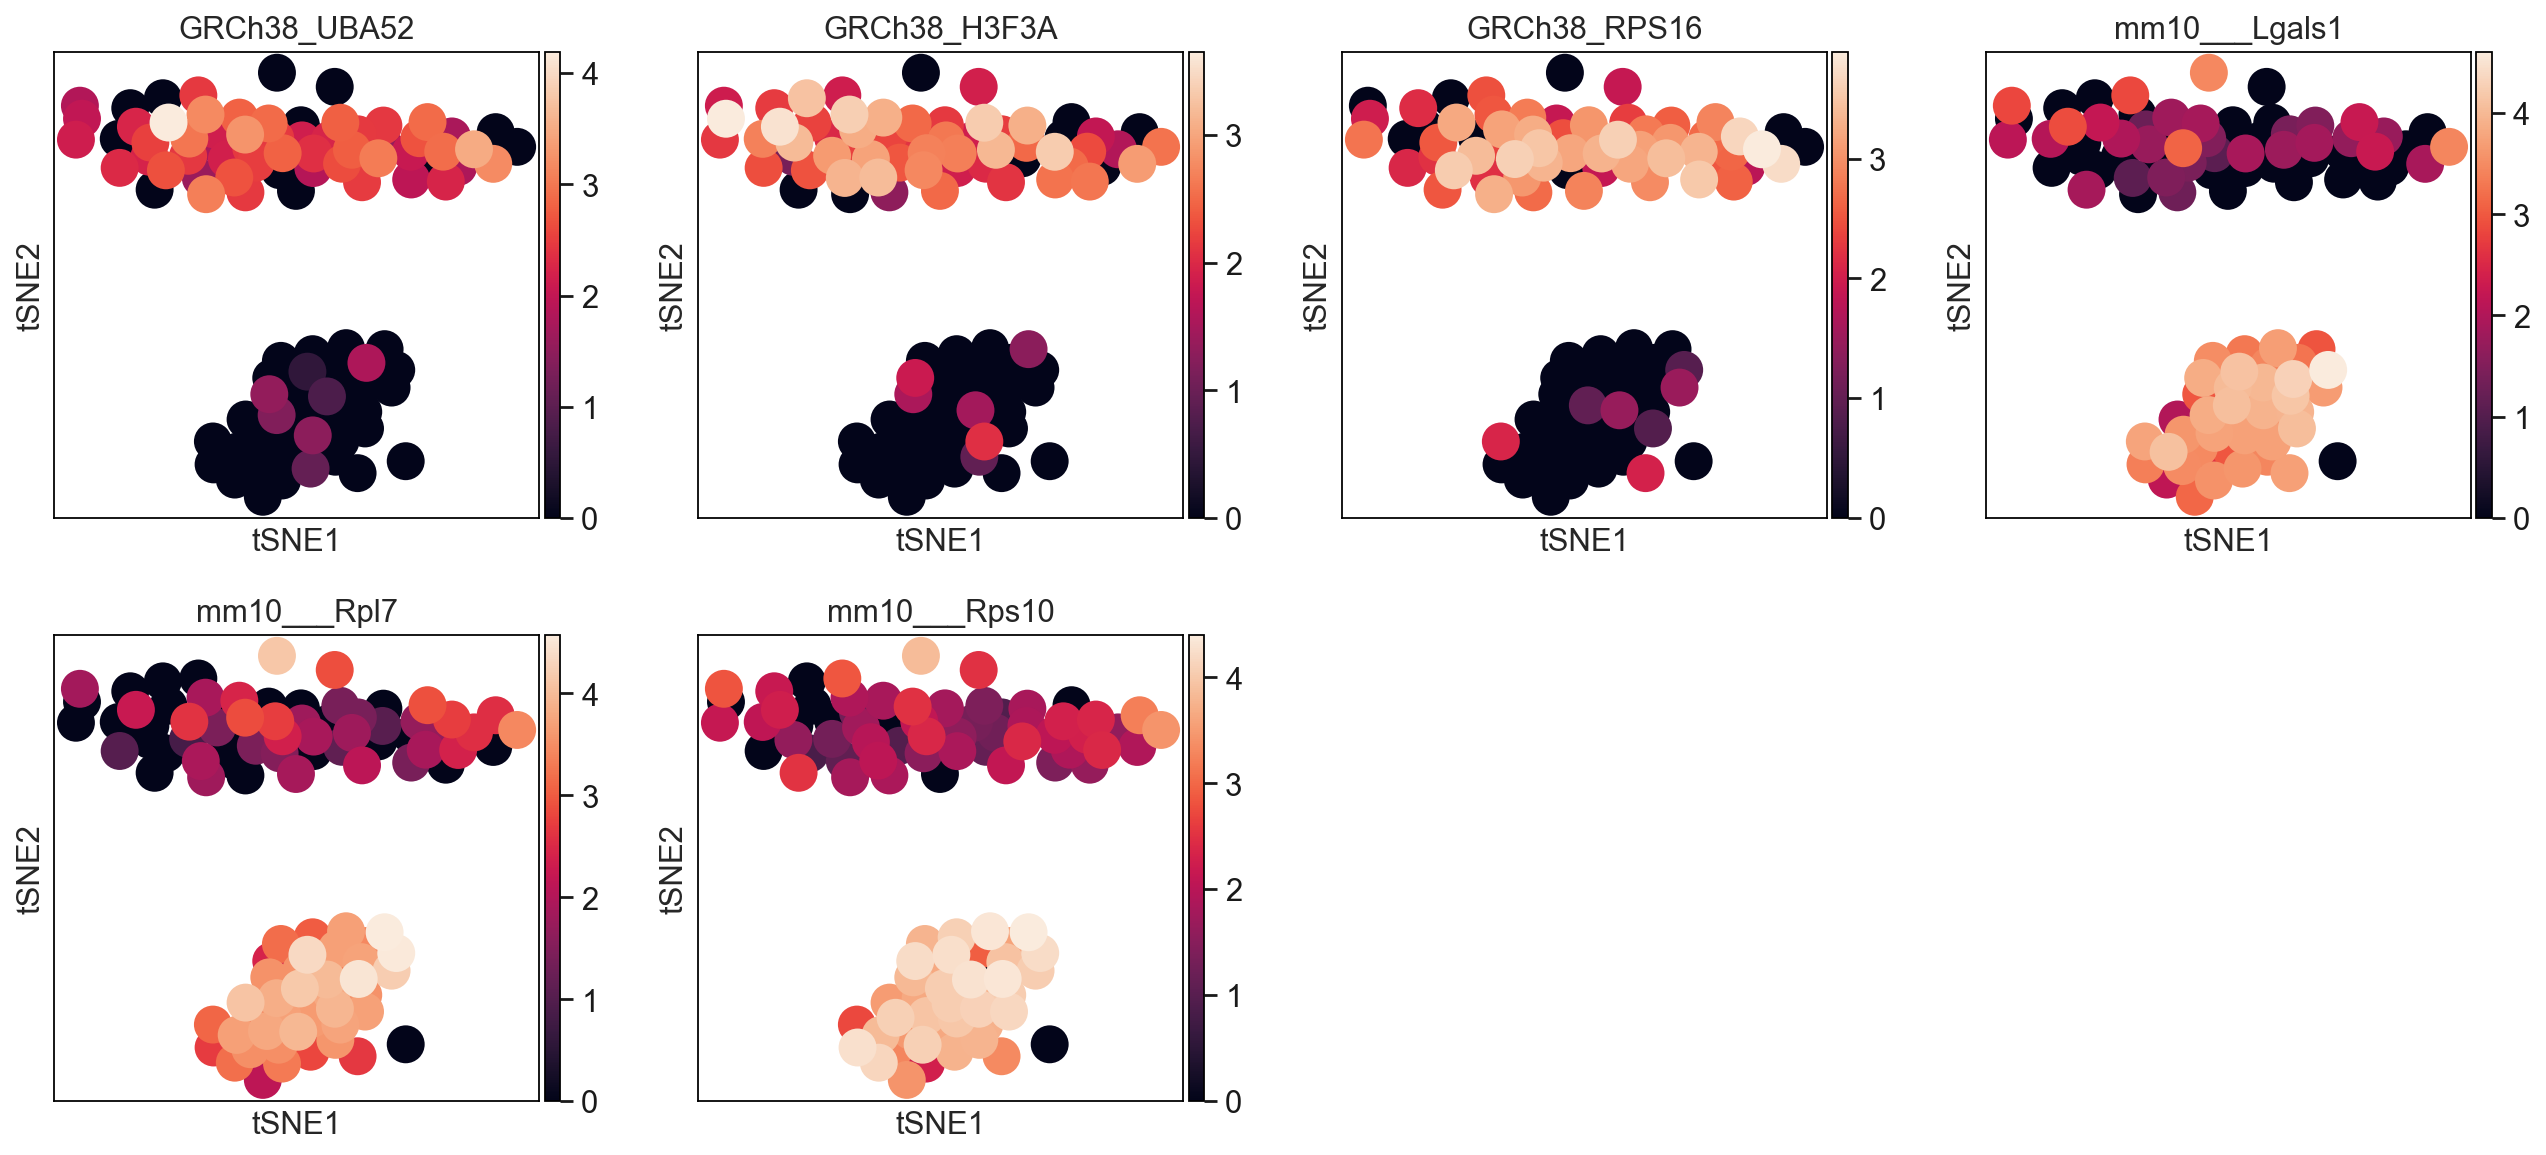

In [24]:
# Computing the neighborhood graph
sc.pp.neighbors(pc_HVG_data, n_neighbors = 15, n_pcs = dim)

# Visualize data with umap
sc.tl.umap(pc_HVG_data)

# Visualize markergene expression (Selected from contribution of each gene to PCA plot)
sc.pl.umap(pc_HVG_data, color = ["GRCh38_UBA52","GRCh38_H3F3A","GRCh38_RPS16","mm10___Lgals1","mm10___Rpl7","mm10___Rps10"])

# Visualize data with t-SNE (Selected from contribution of each gene to PCA plot)
sc.tl.tsne(pc_HVG_data, n_pcs = dim)
sc.pl.tsne(pc_HVG_data, color = ["GRCh38_UBA52","GRCh38_H3F3A","GRCh38_RPS16","mm10___Lgals1","mm10___Rpl7","mm10___Rps10"])



running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


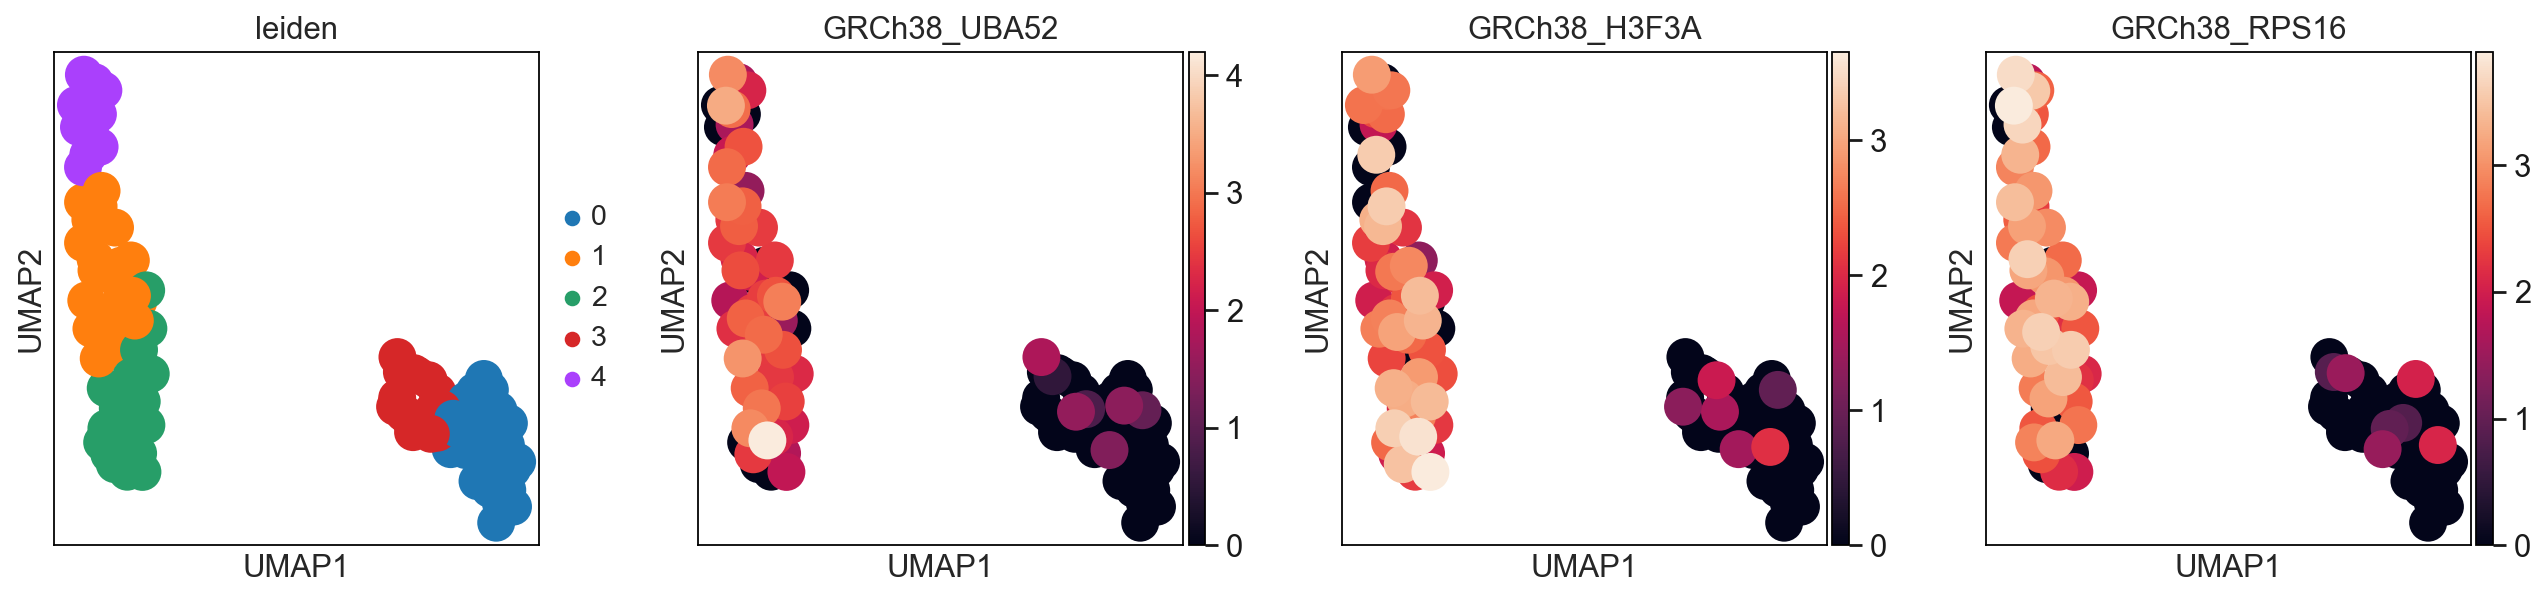

In [25]:
# Clustering the neighborhood graph
# run leiden clustering

sc.tl.leiden(pc_HVG_data, resolution=1)

sc.pl.umap(pc_HVG_data, color = ["leiden","GRCh38_UBA52","GRCh38_H3F3A","GRCh38_RPS16"])